<a href="https://colab.research.google.com/github/leesominn/ProjectDL/blob/main/6label_chat_KoBert_bestmodel_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab 기본 환경 설정

In [ ]:
from IPython.display import clear_output 

!pip install transformers==4.8.2
!pip install sentencepiece==0.1.96
!pip install tensorflow_addons

clear_output()

import sklearn
from sklearn import model_selection
from sklearn.metrics import accuracy_score 

import transformers
from transformers import BertTokenizer, TFBertModel

import tensorflow as tf
import tensorflow_addons as tfa # Rectified-Adam optimizer 사용하기 위해 
from tensorflow.keras import layers, initializers, losses, optimizers, metrics, callbacks

print(sklearn.__version__) # 1.0.2
print(tf.__version__) # 2.8.2
print(transformers.__version__) # 4.8.2
print(tfa.__version__) # 0.18.0

import sentencepiece

import pandas as pd
import numpy as np

import os
import re
import pickle 
import dill # pkl파일로 저장하기 위해
import logging 
import urllib.request
from tqdm import tqdm

import sentencepiece as spm

1.0.2
2.8.2
4.8.2
0.18.0


In [ ]:
# Random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# Transformers logging level 변경 (WARNING -> ERROR) @ https://huggingface.co/transformers/main_classes/logging.html
transformers.logging.set_verbosity(transformers.logging.ERROR)

# Tensorflow logging level 변경 
tf.get_logger().setLevel(logging.ERROR)

## github에서 KoBERT 파일을 로드 및 KoBERT모델 불러오기

In [ ]:
#KoBERT 불러오기
!git clone https://github.com/monologg/KoBERT-Transformers.git
!mv KoBERT-Transformers/kobert_transformers/tokenization_kobert.py /content
clear_output() 

In [ ]:
#토크나이저 생성

tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

## 한국어 대화 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/미니프로젝트03/data/chat_6label.csv', encoding='utf-8', index_col=0)
df

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
45475,뭐? 다시 한 번 말해봐.,분노
45476,어? 정말요?,놀람
45477,"혹시, 다들 은행 계좌없는 거예요?",놀람
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,분노


## 데이터 전처리

### 감정 라벨링

In [ ]:
df.groupby('Emotion').count()

,Sentence
Emotion,
공포,5468
놀람,10764
분노,9293
슬픔,7239
행복,7067
혐오,5649


- 공포:0, 놀람:1, 분노:2, 혐오:3, 슬픔:4, 행복:5

In [ ]:
df['Emotion'] = df['Emotion'].str.replace('공포', '0')
df['Emotion'] = df['Emotion'].str.replace('놀람', '1')
df['Emotion'] = df['Emotion'].str.replace('분노', '2')
df['Emotion'] = df['Emotion'].str.replace('혐오', '3')
df['Emotion'] = df['Emotion'].str.replace('슬픔', '4')
df['Emotion'] = df['Emotion'].str.replace('행복', '5')

In [ ]:
df

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
45475,뭐? 다시 한 번 말해봐.,2
45476,어? 정말요?,1
45477,"혹시, 다들 은행 계좌없는 거예요?",1
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,2


In [ ]:
df = df.rename(columns={'Emotion':'Label'})

In [ ]:
df

,Sentence,Label
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
45475,뭐? 다시 한 번 말해봐.,2
45476,어? 정말요?,1
45477,"혹시, 다들 은행 계좌없는 거예요?",1
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,2


## train, test 데이터 분리

- 여기서 random_state값을 42 -> 0 으로 변경 후 과대적합 문제가 조금 나아짐
- 1,2,3... 조금씩 숫자를 올려가면 최적의 조합을 찾아야함 

- 최적의 조합 : random_state=2

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Sentence'], df['Label'], 
                                                                    test_size=0.3, 
                                                                    random_state=2) # 0으로 지정해서 매번 순서가 다르게 만듦(값을 조정하면서 과대적합 해결해보기)

In [ ]:
# 문장 최대 길이 확인 -> 299이므로 max_lengh=300으로 지정
df['Sentence'].str.len().sort_values(ascending=False)[:5]

13808    299
27433    298
33339    295
31758    261
43296    209
Name: Sentence, dtype: int64

In [ ]:
train_x

17567                           너무 괴롭습니다..
6331                      박섯민 토템설 7년연속 ㅎㄷㄷ
19610                           로이스터 그립다ㅠㅠ
16609             비겁하고 멍청하고 뻔뻔한 여자같으니라고 ㅉㅉ
39834                         우리 얘기 좀 해요! 
                       ...                
43723                  아, 저요?!! 준비, 완벽하죠? 
32511         대가리에 똥만 가득 차 가지고는, 에이~~~퇴!!!
5192      괴롭히고싶은데제가 나중에 아기를 낳으면 모성애가 생길까요?
12172                      철저하게조사해서처벌해야합니다
33003                 저건 엄마가 아니라 미친 여들이여!!
Name: Sentence, Length: 31836, dtype: object

In [ ]:
# train 데이터 문장, 라벨링 확인
print(train_x.iloc[0], train_y.iloc[0])

 너무 괴롭습니다.. 4


## 모델링

### train 데이터 정제(train_inputs, train_labels)

In [ ]:
SEQ_LEN = 300

token_ids = []
token_segments = []
token_masks = []

# token_ids : 문장을 토크나이즈해서 인덱스 값으로 변환
# token_segments : 0과 1로 문장의 토큰 값을 분리(첫번째 문장=0, 두번째 문장=1) -> 문장 구분용
# token_masks : 패딩된 부분은 학습에 영향을 받지 않게 처리해주는 입력 값(문장=1, 패딩=0)    

train_labels = []

for idx in tqdm(range(len(train_x))):

  # 'Sentence'컬럼에서 0번째 행~ 꺼내오기
  train_sentence = train_x.iloc[idx] 

  # 모든 특수문자 제거
  cleaned_sentence = re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', train_sentence)
  
  # 토큰화 + 토큰별 시퀀스번호 부여 + 패딩
  encoded_dict = tokenizer.encode_plus(text = cleaned_sentence,
                                       padding='max_length',
                                       truncation=True, #True 인 경우 모델이 입력으로 받을 수 있는 최대의 길이에 맞춰서 truncation
                                       # truncation : 음절이나 어절 기준이 아닌 토크나이징했을 때의 토큰 기준으로 자르는 것
                                       max_length=SEQ_LEN
                                       )
  
  #'input_ids', 'token_type_ids', 'attention_mask'
  token_ids.append(encoded_dict['input_ids'])
  token_masks.append(encoded_dict['attention_mask'])
  token_segments.append(encoded_dict['token_type_ids'])

  train_labels.append(train_y.iloc[idx])


train_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
train_labels = np.array(train_labels)

100%|██████████| 31836/31836 [00:10<00:00, 2916.29it/s]


In [ ]:
# train 데이터 shape 확인
print(train_labels.shape, train_inputs[0].shape, train_inputs[1].shape, train_inputs[2].shape)

(31836,) (31836, 300) (31836, 300) (31836, 300)


In [ ]:
# 샘플 train 데이터 확인
tokenizer.decode(train_inputs[0][0])

'[CLS] 그동안 운동안했는데 걱정돼여 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

### 모델 생성

In [ ]:
def emo_model(max_length=300):

    bert_base_model = TFBertModel.from_pretrained('klue/bert-base', from_pt=True) 

    input_token_ids   = layers.Input((max_length,), dtype=tf.int32, name='input_token_ids')   
    input_masks       = layers.Input((max_length,), dtype=tf.int32, name='input_masks')       
    input_segments    = layers.Input((max_length,), dtype=tf.int32, name='input_segments')      

    bert_outputs = bert_base_model([input_token_ids, input_masks, input_segments]) 
    
    bert_outputs = bert_outputs[1] 
    bert_outputs = layers.Dropout(0.5)(bert_outputs) # 과대적합 해결을 위해 0.2-> 0.5로 변경
    final_output = layers.Dense(units=6, activation='softmax', kernel_initializer=initializers.TruncatedNormal(stddev=0.02), name='classifier')(bert_outputs)
    # unit=6 <-6가지 감정

    model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], outputs=final_output)

    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.0001, weight_decay=0.0025, warmup_proportion=0.05)
    loss = losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss, 
                  metrics=[metrics.SparseCategoricalAccuracy()])
    
    return model

In [ ]:
print(type(token_ids[0][0]))
print(type(token_masks[0][0]))
print(type(token_segments[0][0]))

<class 'int'>
<class 'int'>
<class 'int'>


- 학습 오류 해결책 > train_labels을 int로 변경해줘야 함

In [ ]:
train_labels = train_labels.astype(np.int32)

In [ ]:
train_labels.dtype

dtype('int32')

In [ ]:
# TPU setting

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("\nAll devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope(): 
  model = emo_model(max_length=300)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
checkpoint_path = '/content/drive/MyDrive/미니프로젝트03/save_model/'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'best_bert_weights_v3.h5', 
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                save_weights_only = True, 
                                                verbose=1) 
                                                
earlystopping = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                             min_delta=0.0001, 
                                             patience=5)

## 학습

In [ ]:
history = model.fit(train_inputs, train_labels, validation_split=0.25,
                    epochs=10, batch_size=64,
                    verbose=1,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/10
374/374 [==============================] - ETA: 0s - loss: 0.2454 - sparse_categorical_accuracy: 0.9213
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.93454, saving model to /content/drive/MyDrive/미니프로젝트03/save_model/best_bert_weights_v3.h5
374/374 [==============================] - 84s 224ms/step - loss: 0.2454 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.2197 - val_sparse_categorical_accuracy: 0.9345
Epoch 2/10
374/374 [==============================] - ETA: 0s - loss: 0.1247 - sparse_categorical_accuracy: 0.9601
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.93454
374/374 [==============================] - 77s 207ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.9236
Epoch 3/10
374/374 [==============================] - ETA: 0s - loss: 0.1080 - sparse_categorical_accuracy: 0.9654
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.93454
374/374 [

In [ ]:
# history.history

{'loss': [1.1917341947555542,
  0.9003767967224121,
  0.6640518307685852,
  0.461836040019989,
  0.30878326296806335,
  0.22165854275226593,
  0.17956390976905823],
 'sparse_categorical_accuracy': [0.5334537625312805,
  0.6544290781021118,
  0.7474477887153625,
  0.8268022537231445,
  0.8888801336288452,
  0.9223338961601257,
  0.9390608072280884],
 'val_loss': [1.0272232294082642,
  1.0462623834609985,
  1.1301745176315308,
  1.296191930770874,
  1.3541697263717651,
  1.6034915447235107,
  1.7534185647964478],
 'val_sparse_categorical_accuracy': [0.59375,
  0.6045854091644287,
  0.5987751483917236,
  0.5994032621383667,
  0.5992462038993835,
  0.5887248516082764,
  0.5854271054267883]}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

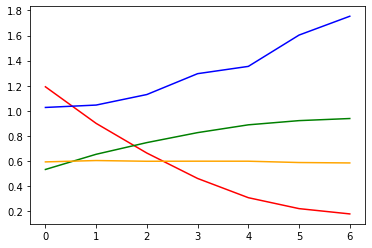

In [ ]:
# 시각화(loss, val_loss, acc, val_acc)
history.history.keys()

loss = history.history['loss']
x = np.arange(len(loss))

plt.plot(x, loss, c='red', label='loss')
plt.plot(x, history.history['val_loss'], c='blue', label='val_loss')
plt.plot(x, history.history['sparse_categorical_accuracy'], c='green', label='acc')
plt.plot(x, history.history['val_sparse_categorical_accuracy'], c='orange', label='val_acc')

plt.legend()

plt.show()

## 모델 저장

In [ ]:
save_path = '/content/drive/MyDrive/미니프로젝트03/save_model/'

with open(save_path + 'model_BERTfunction_fin.pkl', 'wb') as f:
    pickle.dump(dill.dumps(emo_model), f) 

with open(save_path + 'tokenizer-bert_fin.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## 모델 불러오기

In [ ]:
save_path = '/content/drive/MyDrive/미니프로젝트03/save_model/'

with open(save_path + 'model_BERTfunction_fin.pkl', 'rb') as f:
    emo_model = dill.loads(pickle.load(f)) # use dill to pickle a python function

# 2) Load the Bert-tokenizer 
with open(save_path + 'tokenizer-bert_fin.pkl', 'rb') as f:
    tokenizer = pickle.load(f) 


# 3) Create the model & load the Model-weights (from checkpoint file)
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver) # Obsolete : tf.distribute.experimental.TPUStrategy()

with strategy.scope(): 
    model = emo_model(max_length=300) 

checkpoint_path = '/content/drive/MyDrive/미니프로젝트03/save_model/'
model.load_weights(filepath=checkpoint_path + 'best_bert_weights_fin.h5')